# **Librairies**

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from keras import layers as L
from tensorflow.keras import Model
from keras import backend as K
import seaborn as sn; sn.set(font_scale=1.4)

# **Configuration**

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


In [4]:
# OBTENIR LE JUSTIFICATIF D'IDENTITE DU SDK DU CLOUD
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()

# DEFINIR LES IDENTIFIANTS
user_secrets.set_tensorflow_credential(user_credential)

# UTILISER UN APPEL FAMILIER POUR OBTENIR LE CHEMIN GCS DES DONNEES
from kaggle_datasets import KaggleDatasets
GCS_DS_PATH = KaggleDatasets().get_gcs_path('valeo-tf')

# Paramètres

In [5]:
# FIXER LA GRAINE POUR K-FOLD
SEED = 42

# TAILLE DES IMAGES À CHARGER
IMAGE_SIZE = 512

# NOMBRE DE BLOCS 
FOLDS = 5

# TAILLE DES BATCHS ET EPOCHS
BATCH_SIZE = 32
EPOCHS = 50

# POIDS DES BLOCS LORS DE LA PREVISION SUR TEST
WGTS = [1/FOLDS]

# **Importation des données**

In [6]:
TRAIN_FILENAMES = tf.io.gfile.glob(str(GCS_DS_PATH + '/train_tfrec/train_tfrec/*.tfrec'))
TEST_FILENAMES = tf.io.gfile.glob(str(GCS_DS_PATH + '/test_tfrec/test_tfrec/*.tfrec'))

# EXTRAIRE LE NOMBRE DE FICHIERS A PARTIR DU NOM
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

train_samples = count_data_items(TRAIN_FILENAMES)
test_samples = count_data_items(TEST_FILENAMES)

print(f'Train TFRecord files: {len(TRAIN_FILENAMES)}')
print(f'Train image files: {train_samples}')
print(f'Test TFRecord files: {len(TEST_FILENAMES)}')
print(f'Test image files: {test_samples}')

Train TFRecord files: 6
Train image files: 10609
Test TFRecord files: 1
Test image files: 1989


# Fonctions auxiliaires

In [10]:
#LIRE L'IMAGE ET LA MODIFIER
def prepare_image(image, normalize=True, augment=True, dim=IMAGE_SIZE):
    image = tf.image.decode_jpeg(image, channels=3)           #Décodage d'une image codée en JPEG vers un tensor uint8
    
    if normalize :                                            #Normaliser les données pour réduire la plage des valeurs RVB
        image = tf.cast(image, tf.float32) / 255.0 
    
    if augment:                                               #Augmentation des données pour réduire le sur-apprentissage
        image = tf.image.random_flip_left_right(image)        #Renversement aléatoire gauche / droite
        image = tf.image.random_flip_up_down(image)           #Renversement aléatoire gauche / droite
        image = tf.image.random_hue(image, 0.01)              #Ajustement aléatoire de la teinte
        image = tf.image.random_saturation(image, 0.7, 1.3)   #Ajustement aléatoire de la saturation
        image = tf.image.random_contrast(image, 0.8, 1.2)     #Ajustement aléatoire du contraste
        image = tf.image.random_brightness(image, 0.1)        #Ajustement aléatoire de la luminosité
    
    image = tf.reshape(image, (dim, dim, 3))                  #Ajuster la taille de l'image

    return image

#LIRE FORMAT TFRECORD AVEC LABEL
def read_labeled_tfrecord(example):
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),   #Nom de l'image
        'image':      tf.io.FixedLenFeature([], tf.string),   #Valeurs des canaux RVB de l'image
        'label':      tf.io.FixedLenFeature([], tf.int64)     #Variable cible de l'image
    }
    example = tf.io.parse_single_example(example, 
                                         tfrecord_format)     #Analyse une image au format tfrecords
    return example['image'], example['label'] 

#LIRE FORMAT TFRECORD SANS LABEL
def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image' :      tf.io.FixedLenFeature([], tf.string),
        'image_name' : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, 
                                         tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

#LIRE ET TRANSFORMER L'ENSEMBLE DE DONNEES
def get_dataset(filenames, dim=IMAGE_SIZE, labeled=True, return_image_names=True, normalize=True, augment=True, repeat=True, shuffle=True, batch_size=16):

    ds = tf.data.TFRecordDataset(filenames, 
                                 num_parallel_reads=AUTO)     #Ensemble de données comprenant des enregistrements provenant de fichiers TFRecord
    ds = ds.cache()                                           #Garde les images en mémoire après leur chargement hors du disque au cours de la première époque
    
    if repeat:
        ds = ds.repeat()                                      #Répète les éléments
        
    if shuffle:
        ds = ds.shuffle(1024*8)                               #Mélange les éléments   
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled:                                               #Lire les images avec leur label                                           
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else :
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO) 
                                                              #Transformer les images
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, normalize=normalize, augment=augment, dim=dim), imgname_or_label), num_parallel_calls=AUTO)
    
    ds = ds.batch(32* REPLICAS)
    ds = ds.prefetch(AUTO)                                    #Chevauche le prétraitement des données et l'exécution du modèle pendant l'entraînement
        
    return ds

#AFFICHE QUELQUES IMAGES AVEC LEUR LABEL
def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        image, label = example_sample
        numpy_image = image.numpy()
        numpy_label = label.numpy()
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(numpy_image[0][0])
        plt.title(numpy_label[0][0])
    plt.show()
    
#SCORE AVEC SKLEARN                
def custom_metric(y_true, y_pred, lambda_=100):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    score = 1 / len(y_true) * (fn + lambda_ * fp)
    return score

#SCORE AVEC TF
def custom_loss_wrapper(fn_cost=1, fp_cost=100):
    def custom_loss(y_true, y_pred, fn_cost=fn_cost, fp_cost=fp_cost):
        y_true=tf.cast(y_true, tf.float32)
        h = K.ones_like(y_pred)
        fn_value = fn_cost * h
        fp_value = fp_cost * h
        weighted_values = y_true * K.abs(1-y_pred)*fn_value + (1-y_true) * K.abs(y_pred)*fp_value

        loss = K.mean(weighted_values)
        return loss
    return custom_loss

In [8]:
full_ds = get_dataset(TRAIN_FILENAMES)
test_ds = get_dataset(TEST_FILENAMES, augment=False, repeat=False, shuffle=False)

# Analyse exploratoire des données

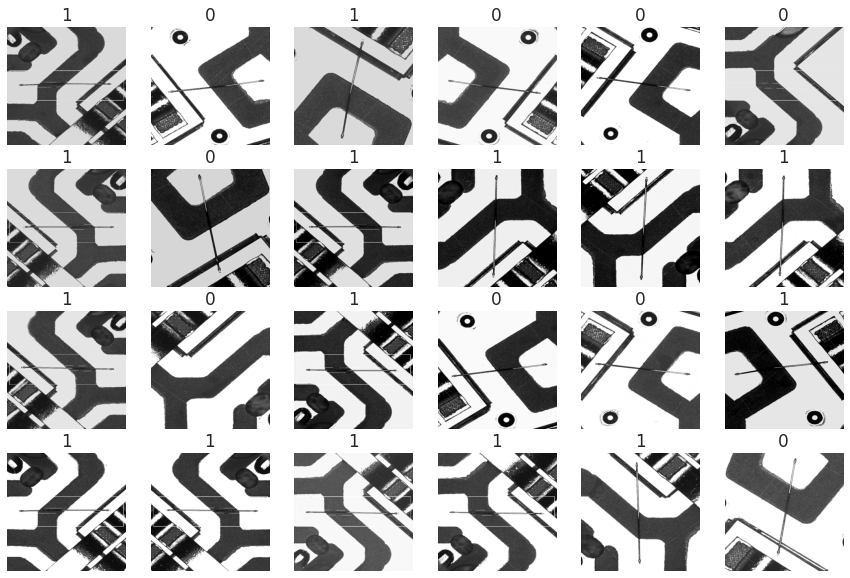

In [11]:
display_samples(get_dataset(TRAIN_FILENAMES, augment=True).batch(1), 4, 6)

# Modélisation

In [17]:
#CONSTRUIRE LE MODELE
def build_model(dim):
    base_model = tf.keras.applications.Xception(input_shape=(dim, dim, 3),  #Utiliser le modèle Xception préformé à partir des données imagenet
                                                include_top=False, 
                                                weights='imagenet')
    
    inputs = tf.keras.Input(shape=(dim, dim, 3))
    x = base_model(inputs, training=False)
    x = L.GlobalAveragePooling2D()(x)                                       #Moyenner pour obtenir les entités en un vecteur
    x = L.Dropout(0.2)(x)                                                   #Oublier des neurones pour limiter le sur-apprentissage
    outputs = L.Dense(1, activation='sigmoid')(x)                           
    model = Model(inputs, outputs)
    
    opt = tf.keras.optimizers.Adam(lr=0.0001)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(optimizer=opt, loss=loss, 
                  metrics=['accuracy', custom_loss_wrapper()])
    return model

In [18]:
#CREER UN REPETOIRE POUR SAUVEGARDER LES MODELES
import os
os.mkdir('/kaggle/working/saved_models/')

#NOMMER LE MODELE A CHAQUE BLOC
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [20]:
save_dir = '/saved_models/'
skf = KFold(n_splits=5,shuffle=True,random_state=SEED)

#CALLBACKS
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=7)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, min_lr=0.000001)

#SAUVEGARDER LES RESULTATS
oof_pred = []; oof_tar = []; oof_names = []; oof_folds = [] 
preds = np.zeros((test_samples,1))

#POIDS DES CLASSES
defect = 4027
no_defect = 6582
total = defect+no_defect
weight_for_0 = (1 / defect)*(total)/2.0 
weight_for_1 = (1 / no_defect)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(6))):
    
    print('#'*25); print('#### FOLD',fold+1)
    
    #SEPARER EN TRAIN/VALID
    files_train = tf.io.gfile.glob([GCS_DS_PATH + '/train_tfrec/train_tfrec/train%.2i*.tfrec'%x for x in train_idx])
    np.random.shuffle(files_train) ; print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_DS_PATH + '/train_tfrec/train_tfrec/train%.2i*.tfrec'%x for x in val_idx])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_DS_PATH + '/test_tfrec/test_tfrec/test*.tfrec')))
    
    #CONSTRUIRE LE MODELE
    tf.keras.backend.clear_session()
    with strategy.scope():
        model = build_model(dim=IMAGE_SIZE)
        
        #CHECKPOINT
        checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

        #AJUSTER LE MODELE
        print('Training...')
        history = model.fit(get_dataset(files_train, batch_size=BATCH_SIZE), 
                            epochs=EPOCHS,
                            steps_per_epoch=count_data_items(files_train) / BATCH_SIZE // REPLICAS,
                            validation_data=get_dataset(files_valid, augment=False,repeat=False, shuffle=False, batch_size=BATCH_SIZE),
                            callbacks=[es, reduce_lr, checkpoint],
                            class_weight=class_weight
                           )
        
        #CHARGER LE MEILLEUR MODELE
        print('Loading best model...')
        model.load_weights("/saved_models/model_"+str(fold)+".h5")
        
        #PREDIRE LE BLOC OOF ET IMPORTER LES LABELS ET LES NOMS
        oof_pred.append(model.predict(get_dataset(files_valid, labeled=False, return_image_names=False, repeat=False, shuffle=False, batch_size=BATCH_SIZE)))
        ds_valid = get_dataset(files_valid, labeled=True, repeat=False, shuffle=False, batch_size=BATCH_SIZE)
        oof_tar.append((np.array([target.numpy() for img, target in iter(ds_valid.unbatch())])))
        oof_folds.append(np.ones_like(oof_tar[-1],dtype='int8')*fold)
        ds = get_dataset(files_valid, labeled=False, return_image_names=True, repeat=False, shuffle=False, batch_size=BATCH_SIZE)
        oof_names.append(np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
        
        #PREDIRE LES DONNEES DE TEST
        ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=False, repeat=False,shuffle=False,batch_size=BATCH_SIZE)
        pred = model.predict(ds_test)
        preds[:,0] += np.mean(pred, axis=1) * WGTS
        
        #RESULTATS
        auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
        
        print('#### FOLD %i OOF AUC = %.3f'%(fold+1,auc))

Weight for class 0: 1.32
Weight for class 1: 0.81
#########################
#### FOLD 1
#########################
83689472/83683744 [==============================] - 1s 0us/step
Training...
Epoch 1/50
25/25 [==============================] - 67s 1s/step - loss: 0.4490 - accuracy: 0.7647 - custom_loss: 12.3326 - val_loss: 0.1858 - val_accuracy: 0.9780 - val_custom_loss: nan

Epoch 00001: val_loss improved from inf to 0.18582, saving model to /saved_models/model_0.h5
Epoch 2/50
25/25 [==============================] - 21s 858ms/step - loss: 0.0526 - accuracy: 0.9826 - custom_loss: 1.1193 - val_loss: 0.1005 - val_accuracy: 0.9594 - val_custom_loss: nan

Epoch 00002: val_loss improved from 0.18582 to 0.10052, saving model to /saved_models/model_0.h5
Epoch 3/50
25/25 [==============================] - 21s 828ms/step - loss: 0.0263 - accuracy: 0.9916 - custom_loss: 0.5347 - val_loss: 0.0333 - val_accuracy: 0.9957 - val_custom_loss: nan

Epoch 00003: val_loss improved from 0.10052 to 0.03325

33/33 [==============================] - 25s 759ms/step - loss: 0.0089 - accuracy: 0.9979 - custom_loss: 0.2079 - val_loss: 0.0179 - val_accuracy: 0.9957 - val_custom_loss: nan

Epoch 00009: val_loss did not improve from 0.01737
Loading best model...
#### FOLD 3 OOF AUC = 1.000
#########################
#### FOLD 4
#########################
Training...
Epoch 1/50
33/33 [==============================] - 84s 1s/step - loss: 0.3605 - accuracy: 0.8478 - custom_loss: 9.5839 - val_loss: 0.0725 - val_accuracy: 0.9778 - val_custom_loss: nan

Epoch 00001: val_loss improved from inf to 0.07250, saving model to /saved_models/model_3.h5
Epoch 2/50
33/33 [==============================] - 25s 768ms/step - loss: 0.0391 - accuracy: 0.9876 - custom_loss: 0.6833 - val_loss: 0.0675 - val_accuracy: 0.9821 - val_custom_loss: nan

Epoch 00002: val_loss improved from 0.07250 to 0.06751, saving model to /saved_models/model_3.h5
Epoch 3/50
33/33 [==============================] - 25s 764ms/step - loss: 0.036

33/33 [==============================] - 25s 771ms/step - loss: 0.0066 - accuracy: 0.9981 - custom_loss: 0.1358 - val_loss: 0.0148 - val_accuracy: 0.9966 - val_custom_loss: nan

Epoch 00013: val_loss did not improve from 0.01403
Epoch 14/50
33/33 [==============================] - 25s 755ms/step - loss: 0.0035 - accuracy: 0.9994 - custom_loss: 0.0781 - val_loss: 0.0149 - val_accuracy: 0.9966 - val_custom_loss: nan

Epoch 00014: val_loss did not improve from 0.01403
Epoch 15/50
33/33 [==============================] - 25s 752ms/step - loss: 0.0043 - accuracy: 0.9991 - custom_loss: 0.0831 - val_loss: 0.0151 - val_accuracy: 0.9966 - val_custom_loss: nan

Epoch 00015: val_loss did not improve from 0.01403
Epoch 16/50
33/33 [==============================] - 25s 745ms/step - loss: 0.0070 - accuracy: 0.9985 - custom_loss: 0.1356 - val_loss: 0.0149 - val_accuracy: 0.9966 - val_custom_loss: nan

Epoch 00016: val_loss did not improve from 0.01403
Epoch 17/50
33/33 [=============================

In [27]:
#CALCULER LA PRECISION DE L'ENSEMBLE OOF
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC = %.3f'%auc)

#SAUVER OOF
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof.ravel(), fold=folds))
df_oof.to_csv('oof.csv',index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.999


,image_name,target,pred,fold
0,AE00005_124507_00_1_2_2001,1,9.996070e-01,0
1,AE00238_072835_00_3_3_2001,0,5.900860e-06,0
2,AE00008_051613_00_2_2_2001,1,9.916785e-01,0
3,AE00238_120427_00_1_2_2001,0,5.960464e-08,0
4,AE00008_074523_00_2_4_2001,1,9.939175e-01,0


In [28]:
#OPTIMISER LE SEUIL
threshold = np.arange(0, 1, 0.1).tolist()
scores = np.arange(0, 1, 0.1).tolist()
df = pd.DataFrame(data={'threshold' : threshold, 'score' : scores})

for i in range(len(threshold)) :
    y_predict = tf.where(df_oof['pred'] < threshold[i], 0, 1).numpy()
    df.loc[i, 'score'] = custom_metric(df_oof['target'], y_predict)
    
df.loc[df['score'] == df['score'].min()]

,threshold,score
9,0.9,0.186823


In [29]:
#SAUVEGARDER LES PREVISIONS DU JEU DE TEST
ds = get_dataset(files_test,labeled=False,return_image_names=True,augment=False, repeat=False,shuffle=False,batch_size=BATCH_SIZE)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission['image_name']=submission['image_name']+str('.jpg')
submission.to_csv('submission.csv', index=False)
submission.head()

,image_name,target
0,AE00008_080949_00_2_2_2001.jpg,9.986112e-01
1,AE00008_091811_00_2_1_2001.jpg,9.989806e-01
2,AE00008_113034_00_4_2_2001.jpg,9.908340e-01
3,AE00018_000155_00_2_4_2001.jpg,9.990863e-01
4,AE00018_022802_00_1_1_2001.jpg,1.370907e-07


In [30]:
#CALCULER L'ERREUR DU JEU DE TEST
random_submission = pd.read_csv('../input/valeo-tf/Random_Submission.csv')
y_test_labels = pd.read_csv('../input/valeo-tf/Y_Test_labels.csv')
random_submission = random_submission.merge(y_test_labels, on='images', how='left')
random_submission = random_submission.drop(['labels_x'], axis=1)
random_submission.columns = ['image_name', 'labels']
random_submission['labels'] = random_submission['labels'].fillna(0)
random_submission = random_submission.merge(submission, on='image_name', how='left')
random_submission.head()

,image_name,labels,target
0,AE00022_095817_00_1_1_2001.jpg,1.0,9.991875e-01
1,AE00382_081204_00_3_4_2001.jpg,1.0,9.972605e-01
2,AE00281_235123_00_2_1_2001.jpg,1.0,9.982089e-01
3,AE00408_051313_00_4_4_2001.jpg,0.0,1.525879e-06
4,AE00379_034020_00_1_2_2001.jpg,0.0,4.172325e-08


In [31]:
y_predict = tf.where(random_submission['target'] < 0.9, 0, 1).numpy()
test_score = custom_metric(random_submission['labels'], y_predict)
print('Custom Metric score = %.3f'%test_score)

Custom Metric score = 0.104


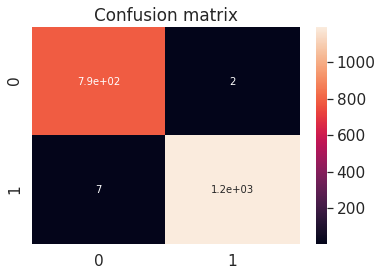

In [32]:
CM = confusion_matrix(random_submission['labels'], y_predict)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=[0, 1], 
           yticklabels=[0, 1], ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [33]:
#FICHIER DE SOUMISSION

random_submission['labels']=y_predict
random_submission = random_submission.drop(['target'], axis=1)
random_submission.columns = ['images', 'labels']
random_submission.to_csv('random_submission.csv', index=False)